### **Christopher Zahasky _ Flopy _ 04_05**

In [1]:
import sys; import flopy; import os; import time; import numpy as np  ; import matplotlib.pyplot as plt
import pathlib; import pandas as pd; import string ; from scipy.special import erfc as erfc   ; from scipy.special import erf as erf
current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\00_BETAMI\w10_______others\01_MT3D_Wisconsin-Madison\04_05


In [2]:
exe_name_mf = 'E:\\15_REPOS\\00_BETAMI\\w10_______others\\bin\\mf2005.exe'
exe_name_mt = 'E:\\15_REPOS\\00_BETAMI\\w10_______others\\bin\\mt3d-usgs_1.1.0_64.exe';    model_ws = '.'

In [3]:
itmuni = 1 ; mt_tunit = 'S'     # MODFLOW | MT3D units    # 1 = seconds,   2 = minutes, 3 = hours,  4 = days,         5 = years 
lenuni = 3 ; mt_lunit = 'CM'    # MODFLOW units          # 0 = undefined, 1 = feet,    2 = meters, 3 = centimeters   
perlen_mf = [30*60]             # format for multi-period input: [60., 15*60]    
nper      = len(perlen_mf)      # number of stress periods (MF input)
nprs      = 100                 # Frequency of output, If nprs > 0 results will be saved at times as specified in timprs; 
timprs    = np.linspace(0, np.sum(perlen_mf), nprs, endpoint=False)

nlay = 1; nrow = 1 ; ncol = 21 ; delv = 4.4; delc = 4.4 ; delr = 0.5 ; laytyp = 0

Lx = (ncol - 1) * delr          # ___________________________________  # 10 = # Lx 
hk = 1; al = 0.3 # long. dispersivity (al)                             # trpt = 0.1 H__al(xy)       # trpv = 0.1 # V__al(Z)
v = 0.014; prsity = 0.3;      q = v * prsity                         # 2x v (***)
print("Based on discharge and model length the approximate ~ breakthrough time = " + str(round(Lx / ( q / prsity) )) + " sec")

Based on discharge and model length the approximate ~ breakthrough time = 714 sec


In [4]:
ibound = np.ones  ((nlay, nrow, ncol), dtype=int)     ; ibound[0, 0, 0] = -1       ; ibound[0, 0, -1] = -1  
strt   = np.zeros ((nlay, nrow, ncol), dtype=float)   ; h1 = q * Lx / hk           ; strt  [0, 0,  0] = h1   ; c0 = 1     
icbund = np.ones  ((nlay, nrow, ncol), dtype=int)  
sconc  = np.zeros ((nlay, nrow, ncol), dtype=float)
itype  = -1     ; spd_mt = {0:[0, 0, 0, c0, itype]}    #  mass \ volume * flow rate =  mass-loading rate (source)

## **MODFLOW**

In [5]:
mf = flopy.modflow.Modflow(modelname='mf04_mf', model_ws=model_ws, exe_name=exe_name_mf)
dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper,delr=delr, delc=delc, top=0., 
                               botm=[0 - delv], perlen=perlen_mf, itmuni=itmuni, lenuni=lenuni)
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)        # v, h1, strt
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp = laytyp)
pcg = flopy.modflow.ModflowPcg(mf)
lmt = flopy.modflow.ModflowLmt(mf)
oc = flopy.modflow.ModflowOc(mf)                          ; mf.write_input() ; mf.run_model(silent = True)     # ____________ MODLFOW _________
mt = flopy.mt3d.Mt3dms(modelname='mt04_mt', model_ws=model_ws, exe_name=exe_name_mt, modflowmodel=mf)  
btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=sconc, tunit=mt_tunit, lunit=mt_lunit, nprs=nprs, timprs=timprs)
mixelm = -1      # Advection package class                  # (0_FDM, 1_MOC, 2_MMOC, 3_HMOC, -1_TVD scheme_ULTIMATE)
adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, percel=0.5)     # percel is the Courant number for numerical stability (≤ 1)
dsp = flopy.mt3d.Mt3dDsp(mt, al=al)                         # Dispersion 
ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data = spd_mt )  # source/sink
gcg = flopy.mt3d.Mt3dGcg(mt, cclose=1e-6)                 ; mt.write_input() ; mt.run_model(silent=True)       # ____________ MT3D ____________

(False, [])

In [6]:
fname   = os.path.join(model_ws, 'MT3D001.UCN')
ucnobj  = flopy.utils.UcnFile(fname)
conc    = ucnobj.get_alldata() 

fname   = os.path.join(model_ws, 'mf04_mf'+'.hds')     # binary
hdobj   = flopy.utils.HeadFile(fname)
heads   = hdobj.get_data()                         

times   = np.array(ucnobj.get_times())                  ; print("T=",times.shape)     ; print("H=",heads.shape)  ; print("C=", conc.shape)

T= (101,)
H= (1, 1, 21)
C= (101, 1, 1, 21)


In [7]:
save = pd.DataFrame(times)                                                       ; save.to_csv  ("04a_T.csv")  
reSHP_H  = heads.reshape (heads.shape[0], -1)  ; then_H = pd.DataFrame(reSHP_H)  ; then_H.to_csv("04b_H.csv")    ; print("H=",then_H.shape) 
reSHP_C  = conc .reshape (conc.shape [0], -1)  ; then_C = pd.DataFrame(reSHP_C)  ; then_C.to_csv("04c_C.csv")    ; print("C=",then_C.shape) 

H= (1, 21)
C= (101, 21)


In [8]:
y, x, z = mf.dis.get_node_coordinates()   ; save  = pd.DataFrame(x); save.to_csv("04d_Grid.csv")

(101, 1, 1, 21)


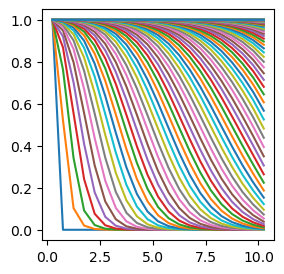

In [9]:
print(conc.shape);   plt.figure(figsize=(3,3)); 
for t in range(0, len(times)):
    cprof = conc[t, 0, 0, :]
    plt.plot(x, cprof)           # now loop through the times and extract concentration profiles

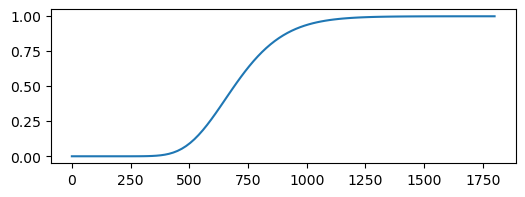

In [10]:
C_btc = conc[:, 0, 0, -1] ; plt.figure(figsize=(6,2))   ; plt.plot(times, C_btc, label='Breakthrough Curve')   ; plt.show()

## **Christopher Zahasky _ Flopy _ 05**

In [11]:
def analytical_model_1D_t1(x, t, v, al):              
    D = v*al ;         Conc_time_type1 = (1/2)*erfc((x - v*t)/(2*np.sqrt(D*t))) + (1/2)*np.exp(v*x/D)*erfc((x + v*t)/(2*np.sqrt(D*t)))
    return Conc_time_type1

def analytical_model_1D_finite_t1(x, t, v, al, L):
    D = v*al
    Conc_time_type1_finite = (1/2)*erfc((x - v*t)/(2*np.sqrt(D*t))) + (1/2)*np.exp(v*x/D)*erfc((x + v*t)/(2*np.sqrt(D*t))) + \
        (1/2)*(2 + (v*(2*L - x)/D) + v**2*t/D)* np.exp(v*L/D)*erfc(((2*L - x)+ v*t)/(2*np.sqrt(D*t))) - \
        (v**2 *t/(3.1415*D))**(1/2) * np.exp(v*L/D - ((2*L - x + v*t)**2)/(4*D*t))
    return Conc_time_type1_finite

def analytical_model_1D_t3(x, t, v, al):
    D = v*al
    Conc_time_type3 = (1/2)* erfc((x - v*t)/(2* np.sqrt(D*t))) + np.sqrt((v**2*t)/(3.1415*D))* np.exp(-(x - v*t)**2/(4*D*t)) - \
    (1/2)*(1 + (v*x/D) + (v**2*t/D))* np.exp(v*x/D)* erfc((x + v*t)/(2* np.sqrt(D*t)))
    return Conc_time_type3

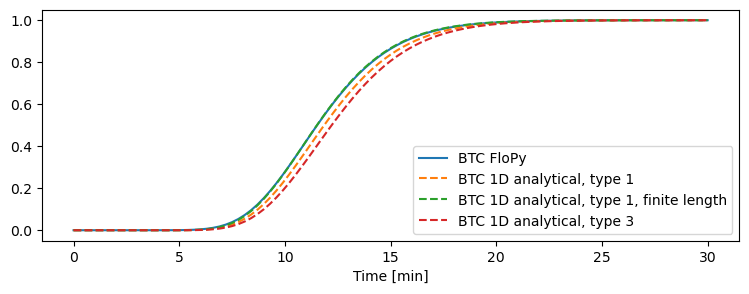

In [12]:
Conc_time_type1  = analytical_model_1D_t1(x[-1],        times, v, al)
Conc_time_ftype1 = analytical_model_1D_finite_t1(x[-1], times, v, al, x[-1])
Conc_time_type3  = analytical_model_1D_t3(x[-1],        times, v, al)
plt.figure(figsize=(9, 3), dpi=100)
plt.plot(times/60, C_btc,                   label = 'BTC FloPy' )
plt.plot(times/60, Conc_time_type1,  '--',  label = 'BTC 1D analytical, type 1')
plt.plot(times/60, Conc_time_ftype1, '--',  label = 'BTC 1D analytical, type 1, finite length')
plt.plot(times/60, Conc_time_type3,  '--',  label = 'BTC 1D analytical, type 3')
plt.xlabel('Time [min]'); plt.legend(); plt.show()

## **1D Analytical Solution Function `   timestep = 05`**

Model time: 1.5 min


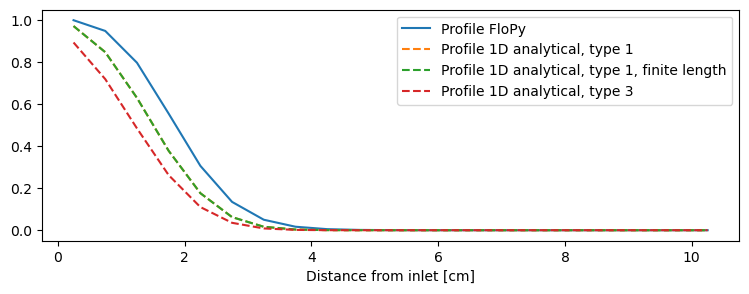

In [13]:
timestep = 5 # A timestep that corresponds to the numerical model output increment, 
Conc_time_type1_x = analytical_model_1D_t1(x, times[timestep], v, al)  
Conc_time_ftype1_x = analytical_model_1D_finite_t1(x, times[timestep], v, al, x[-1])    
Conc_time_type3_x = analytical_model_1D_t3(x, times[timestep], v, al)                   ; C_profile = conc[timestep, 0, 0, :]
plt.figure(figsize=(9, 3), dpi=100)                                                     ; plt.plot(x, C_profile, label='Profile FloPy') 
plt.plot(x, Conc_time_type1_x  , '--', label='Profile 1D analytical, type 1') 
plt.plot(x, Conc_time_ftype1_x , '--', label='Profile 1D analytical, type 1, finite length')
plt.plot(x, Conc_time_type3_x  , '--', label='Profile 1D analytical, type 3')           ; plt.xlabel('Distance from inlet [cm]'); plt.legend()
print('Model time: ' + str(times[timestep]/60) + ' min')                                ; plt.show()

## **1D Analytical Solution Function `timestep = 60`, ... output** 

Model time: 18.0 min


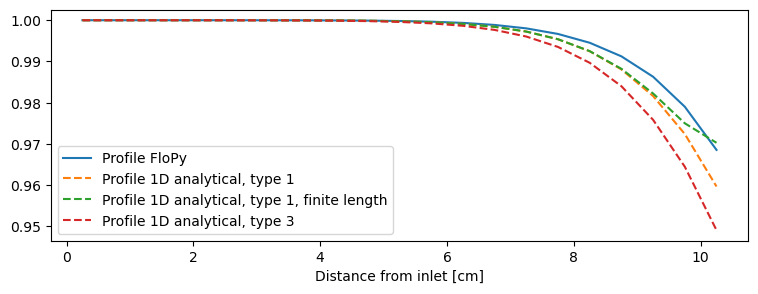

In [14]:
timestep =60 # A timestep that corresponds to the  
Conc_time_type1_x = analytical_model_1D_t1(x, times[timestep], v, al) 
Conc_time_ftype1_x = analytical_model_1D_finite_t1(x, times[timestep], v, al, x[-1])
Conc_time_type3_x = analytical_model_1D_t3(x, times[timestep], v, al)                 ; C_profile = conc[timestep, 0, 0, :]
plt.figure(figsize=(9, 3), dpi=100)                                                   ; plt.plot(x, C_profile, label='Profile FloPy'); 
plt.plot(x, Conc_time_type1_x, '--' , label='Profile 1D analytical, type 1')
plt.plot(x, Conc_time_ftype1_x, '--', label='Profile 1D analytical, type 1, finite length')
plt.plot(x, Conc_time_type3_x, '--' , label='Profile 1D analytical, type 3'); plt.xlabel('Distance from inlet [cm]'); plt.legend()
print('Model time: ' + str(times[timestep]/60) + ' min')                              ; plt.show()